In [104]:
from keras import backend as K

Using TensorFlow backend.


In [105]:
import numpy as np
import pandas as pd

In [106]:
import keras

# Indodax Data Retrieval

In [2]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [3]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = '5'
time_begin = int(datetime.datetime(2017, 1, 1).timestamp())
time_end = int(datetime.datetime(2017, 6, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(price)

43489

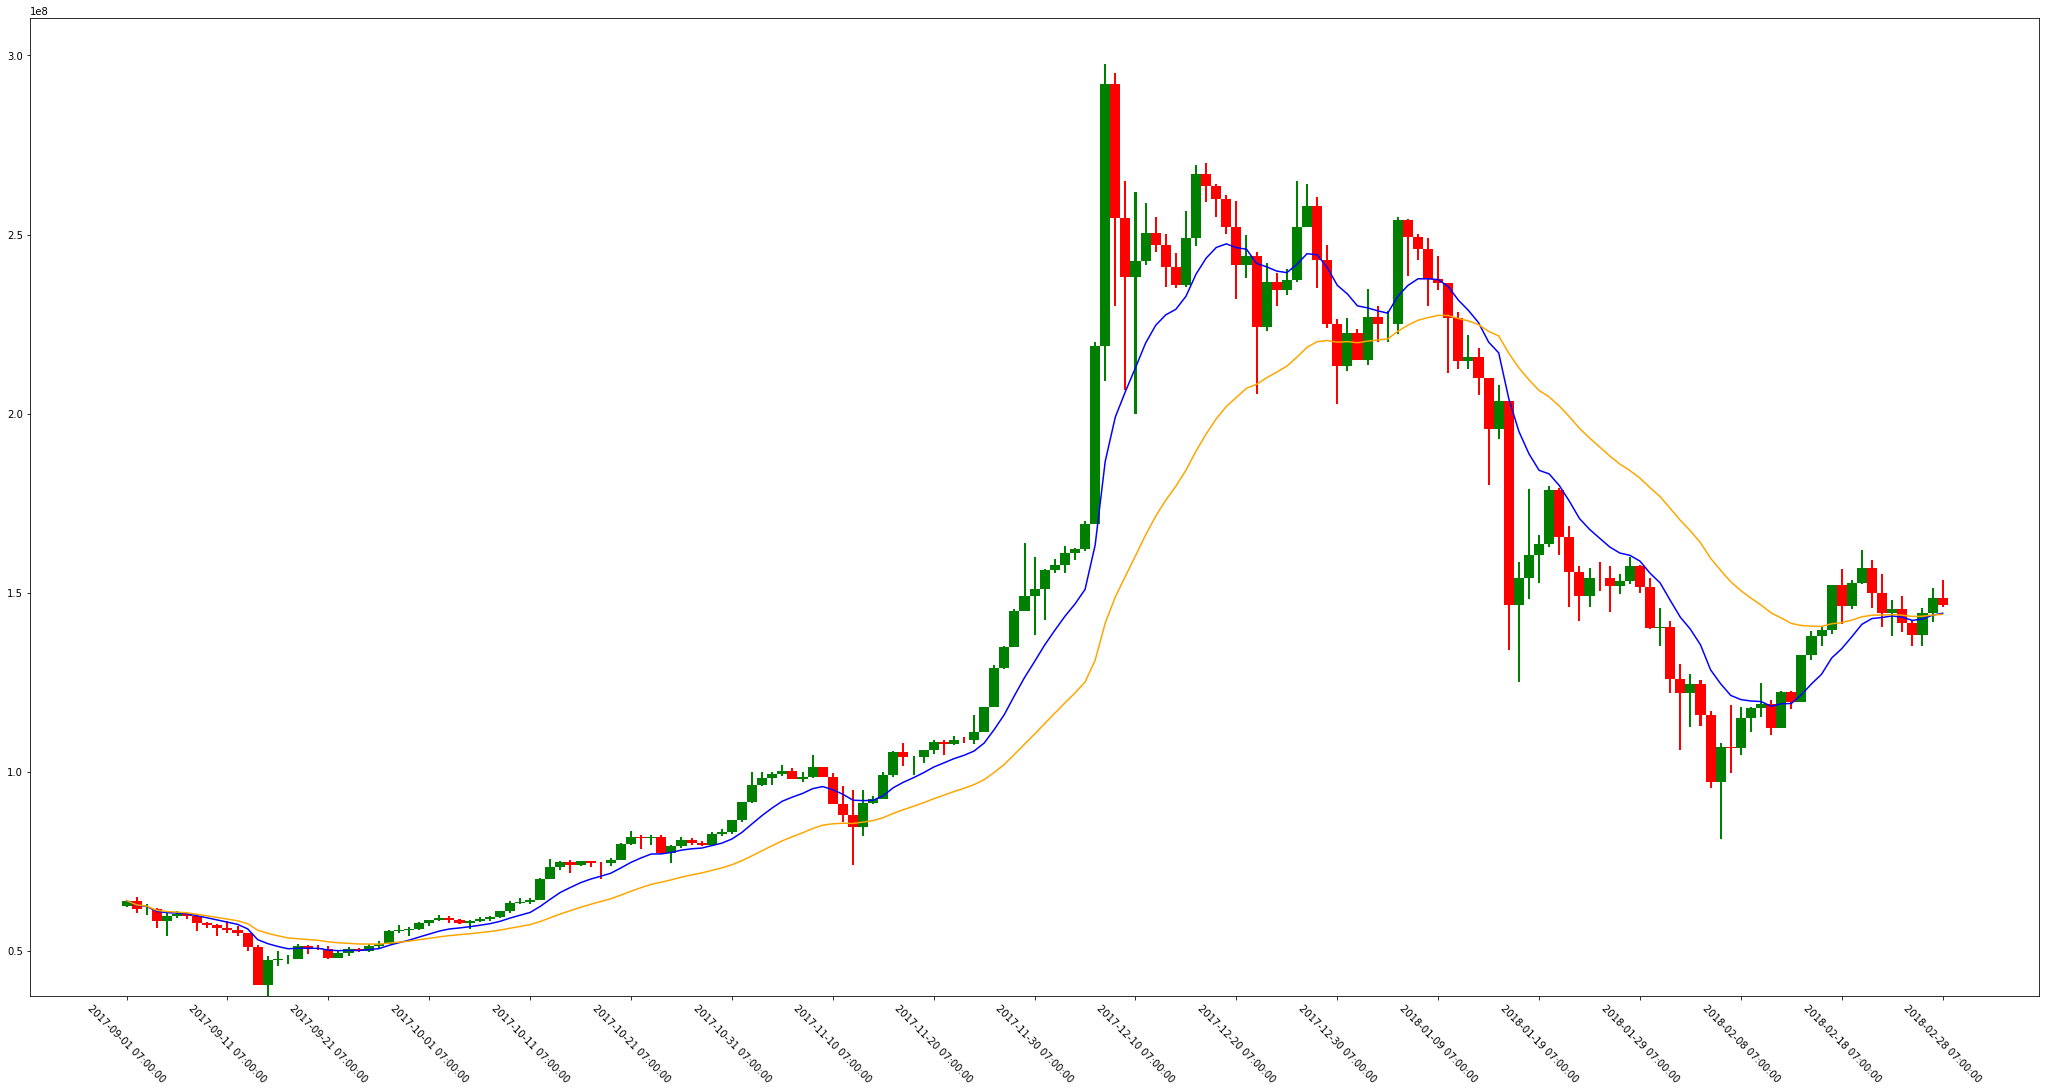

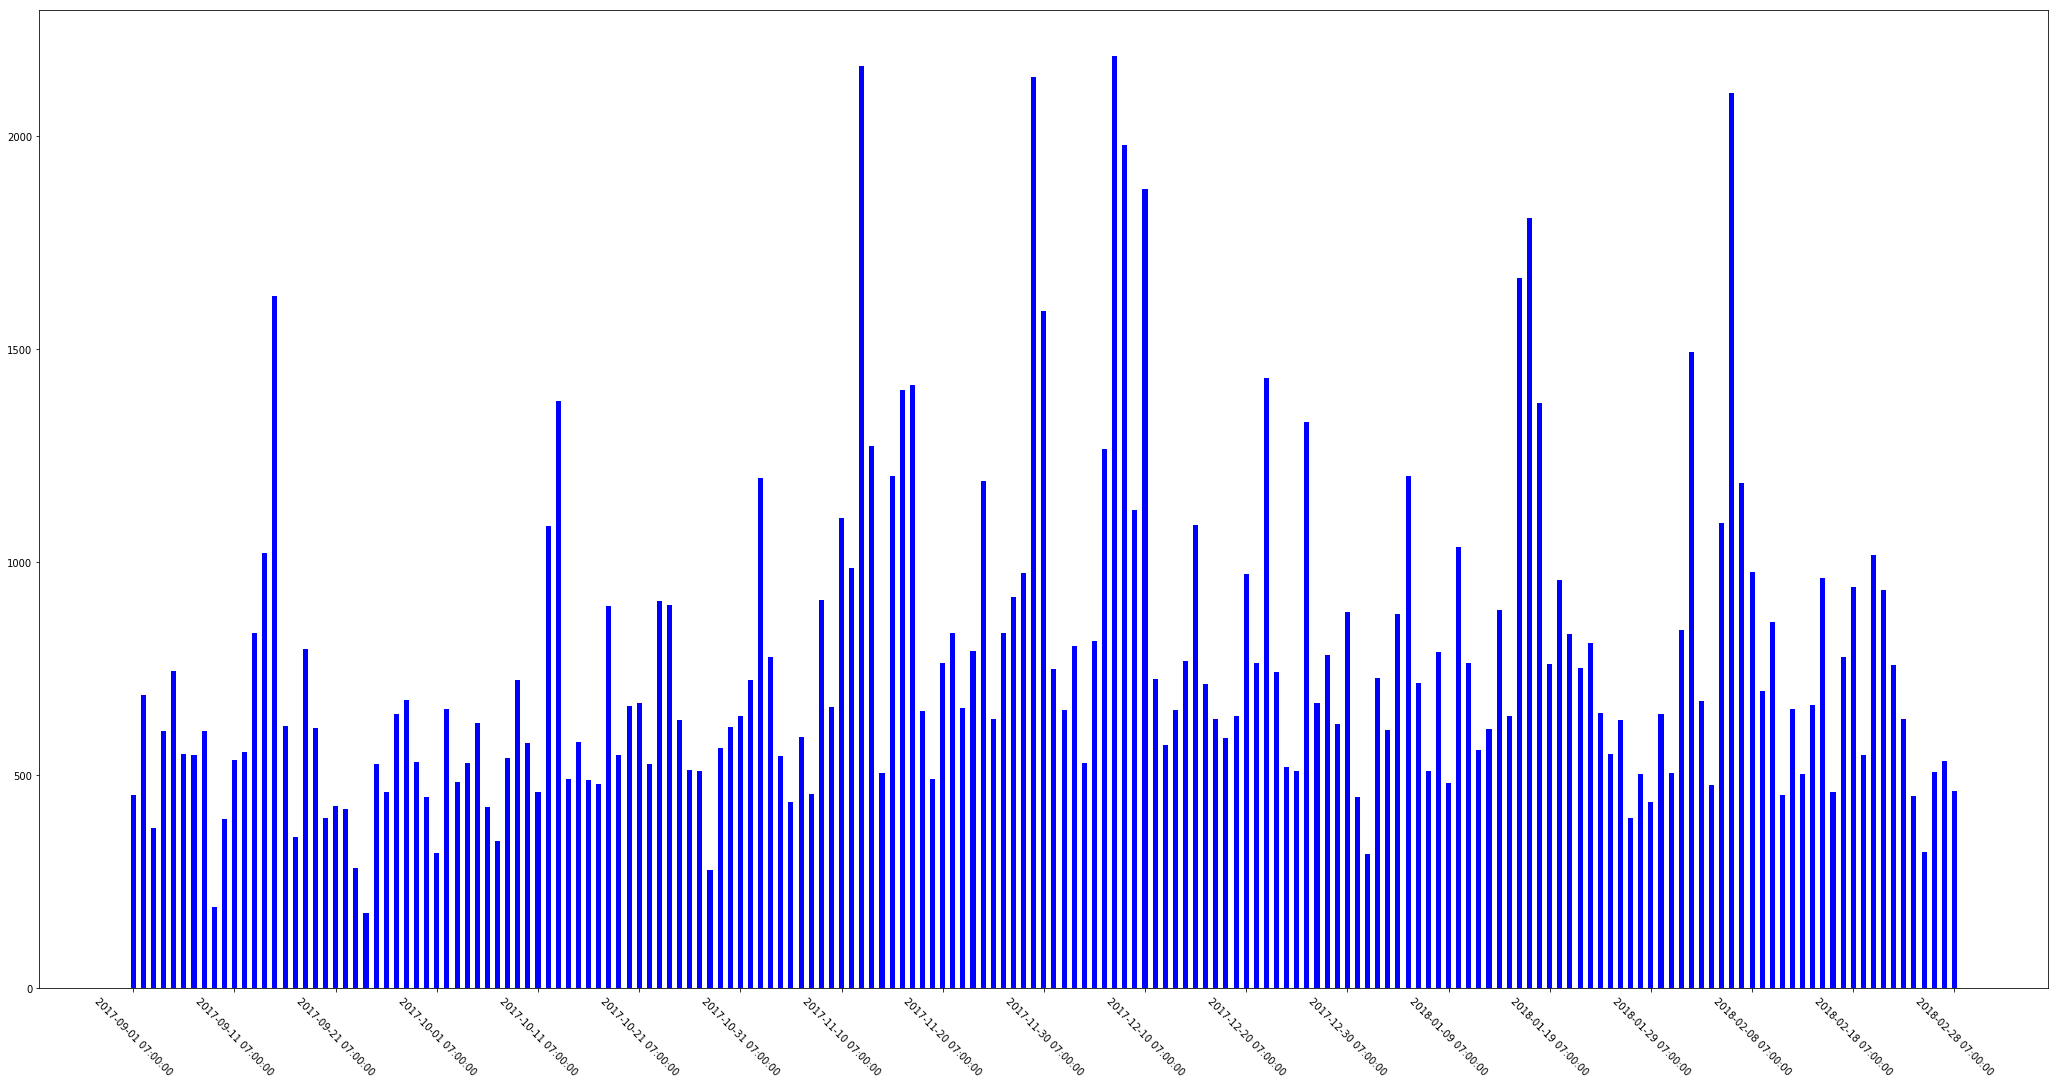

In [401]:
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)

#use this to visualize
plt.show()

In [104]:
action_list = {}
action_list['\\'] = {'action'}
action_list['action'] = []

# weird workaround due to limitation to column name, see below
# HOLD --> 0
# BUY --> -1
# SELL --> 1
for i in range(len(price.index)-1):
    current = price.iloc[i]
    before = price.iloc[i-1]
    after = price.iloc[i+1]
    if current.close < after.close:
        if current.close > before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(-1)
    elif current.close > after.close:
        if current.close < before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(1)
    else:
        action_list['action'].append(0)
action_list['action'].append(0)
action_frame = pd.DataFrame(action_list['action']).set_index(price.index)

# we need the stock price somehow
action_frame = action_frame.join(price)

# column names change 'Action' to 'low'
# weird workaround due to limitation to column name
# reference : https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed.html?highlight=pandasdata
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

# Labeling

In [5]:
close = np.array(price.close)
label = [0 for i in range(len(close))]
profit = [0 for i in range(len(close))]
t_forward = 10
commission = 0.003
min_net_profit = lambda p: p * (1+(2*commission))
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(5)])
    profit[i-t_forward] = close[t_forward] - sample.mean() - (close[t_forward] * commission) - (close[i] * commission)
    if (sample > min_net_profit(close[i-t_forward])).sum() > 4:
        label[i-t_forward] = -1
        label[i] = 1

### Just the profits

In [6]:
close = np.array(price.close)
profit = [0 for i in range(len(close))]
t_forward = 30
for i in range(t_forward, len(price)):
    # sample the future
    sample = np.array([close[i-j] for j in range(15)])
    profit[i-t_forward] = (sample.mean() - close[i] - (sample.mean() * commission) - (close[i] * commission)) / close[i]

In [181]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2043
hold 39617
sell 1829


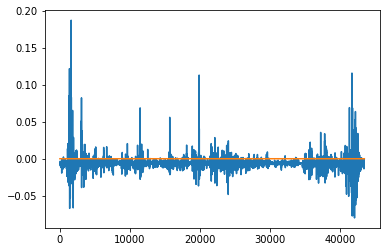

In [7]:
plt.plot(profit)
plt.plot([0 for i in range(len(profit))])

## Label Balancing
More buy

In [182]:
state = 'not buying'
now = 0
for i in range(len(price)-t_forward, -1, -1):
    if state == 'not buying' and label[i] == -1:
        state = 'buying'
        now = close[i]
    if state == 'buying' and label[i] != -1:
        state = 'buy more'
    if state == 'buy more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = -1
        else:
            state = 'not buying'

In [183]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2611
hold 39103
sell 1775


More sell

In [184]:
state = 'not selling'
now = 0
for i in range(t_forward, len(close)):
    if state == 'not selling' and label[i] == 1:
        state = 'selling'
        now = close[i]
    if state == 'selling' and label[i] != 1:
        state = 'sell more'
    if state == 'sell more':
        if close[i] <= now:
            now = price.close[i]
            label[i] = 1
        else:
            state = 'not selling'

In [185]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 2493
hold 38554
sell 2442


In [186]:
action_frame.low = label

In [7]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [187]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [188]:
# data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)
#print(data_feed)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(100000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

In [171]:
93.952555

93.952555

In [122]:
len(action_frame)

52129

# Data Formatting

## Labels
- HOLD: 1
- BUY: 0
- SELL: 2

## Data Format #1
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | trade volume t |
| 3 | close price t-1 |
| 4 | trade volume t-1 |
| 5 | close price t-2 |
| 6 | trade volume t-2 |
| 7 | close price t-3 |
| 8 | trade volume t-3 |
| 9 | close price t-4 |
| 10 | trade volume t-4 |
| 11 | close price t-5 |
| 12 | trade volume t-5 |

In [78]:
train = []
for t in range(period-1, len(price)):
    now = []
    for i in range(period):
        now.append(price.close[t-i])
        now.append(price.volume[t-i])
    train.append(now)
train = np.array(train)

In [86]:
timestep = 6
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep-1:]

## Data Format #2
| Column # | Description |
| --- | --- |
| 1 | close price t |
| 2 | close price t-1 |
| .. | .. | 
| 24 | close price t-23 |

### Data normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [10]:
normalizer = StandardScaler()

In [11]:
price_normalized = normalizer.fit_transform(np.array(price.close)[:,np.newaxis])

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
timestep = 120
target_label = keras.utils.to_categorical(np.array([i+1 for i in action_frame.low]), num_classes=3)[timestep:]

In [15]:
data = []
for t in range(timestep, len(price_normalized)):
    data.append(price_normalized[t-timestep:t])
data = np.array(data)


### Reshape for Recurrent Layer input

In [16]:
data = data.reshape((data.shape[0], timestep, 1))

# Toy Data
It is to make sure that the RNN can recognize simple pattern

In [4]:
BUY = 0
HOLD = 1
SELL = 2
INITIAL_PRICE = 50000000

def generate_hold_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(0, 10) for i in range(length)]), # balanced data
        np.array([HOLD for i in range(length)]) # balanced data
    )

def generate_buy_pattern(last_price, length):
    return (
        np.array([last_price + np.random.normal(i*10, 1) for i in range(length)]),
        np.array([BUY for i in range(length)])
    )

def generate_sell_pattern(last_price, length):
    return (
        np.array([last_price - np.random.normal(i*10, 1) for i in range(length)]),
        np.array([SELL for i in range(length)])
    )

In [55]:
price = np.array([])
label = np.array([])
current_price = INITIAL_PRICE
generators = [generate_hold_pattern, generate_buy_pattern, generate_sell_pattern]
for i in range(100):
    np.random.shuffle(generators)
    for f in generators:
        p, l = f(current_price, np.random.randint(15, 25))
        price = np.append(price, p)
        label = np.append(label, l)
        current_price = p[-1]

In [121]:
len(action_list)

2

# Real Data Preparation

## Labeling

In [8]:
from sklearn.preprocessing import StandardScaler

In [46]:
X = np.array(close)

In [79]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X.reshape(-1,1))
y_norm = X_norm[t_forward:]

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [80]:
timestep = t_forward
ts = []
for t in range(timestep, len(X_norm)):
    ts.append(X_norm[t-timestep:t])
ts = np.array(ts).T[0].T

In [81]:
ts.shape

(43459, 30)

In [82]:
y_norm[0]

array([-0.66093446])

In [83]:
test_split = len(ts) // 10 # percent
X_train = ts[:-test_split]
y_train = y_norm[:-test_split]
X_test = ts[-test_split:]
y_test = y_norm[-test_split:]

In [125]:
len(X_train)

39114

# Visualization

In [210]:
%matplotlib qt

plt_len = 30000
plt.figure(figsize=(40, 5))
plt.plot(X[:plt_len])
plt.figure(figsize=(40, 5))
plt.plot(profit[:plt_len])
plt.plot([0 for i in range(plt_len)])
plt.figure(figsize=(40, 5))
plt.scatter(
    [i for i in range((plt_len))],
    [0 for i in range((plt_len))],
    color=[(1 if i == 2 else 0, 1 if i == 0 else 0, 1 if i == 1 else 0) for i in y[:plt_len]],
    s=5
)

### RNN

In [123]:
X_train_rnn = X_train.reshape((X_train.shape[0], timestep, 1))
# target_label = keras.utils.to_categorical(np.array([i for i in label]), num_classes=3)[timestep:]

In [129]:
for i in range(1, len(X_train_rnn)):
    if len(X_train_rnn) % i == 0:
        print(i)

1
2
3
6
9
18
41
53
82
106
123
159
246
318
369
477
738
954
2173
4346
6519
13038
19557


### Others

In [36]:
train_data = data.T[0].T

In [41]:
train_data.shape

(40157, 20)

In [45]:
y_train[:20]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

# Machine Learning Model: Generalized Linear Models

In [92]:
from sklearn.metrics import mean_absolute_error

In [97]:
from sklearn.linear_model import Lars

In [98]:
reg = Lars()

In [99]:
reg.fit(X_train, y_train)

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)

In [100]:
pred_train = scaler.inverse_transform(reg.predict(X_train))

In [101]:
mean_absolute_error(pred_train, scaler.inverse_transform(y_train))

17921.210259020303

In [102]:
pred_test = scaler.inverse_transform(reg.predict(X_test))

In [103]:
mean_absolute_error(pred_test, scaler.inverse_transform(y_test))

97555.37825431631

# Machine Learning Model: SVM

In [215]:
from sklearn.svm import SVR

In [237]:
clf = SVR()

In [ ]:
clf.fit(X_train, y_train)

C:\Users\yerla\.conda\envs\ml\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [91]:
clf.score(X, y)

0.8276157804459692

# Machine Learning Model: Gradient Boosting

In [109]:
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
clf = GradientBoostingClassifier(n_estimators=200)

In [115]:
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [116]:
clf.score(X,y)

0.9060034305317324

# Machine Learning Model: RNN
4 Layers of Fully connected neural network + 1 softmax layer

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, BatchNormalization, LSTM

### Must set correct batch size
Length of training data must be divisible by batch size

In [130]:
correct_batch_size = 738

In [139]:
def generate_recurrent_layers(units, layers_count):
    return [SimpleRNN(units, return_sequences=True) for i in range(layers_count-1)] + [SimpleRNN(units)]

def generate_fully_connected_layers(units, layers_count, activation='sigmoid'):
    return [Dense(units, activation=activation) for i in range(layers_count)]

def generate_model(batch_size=1):
    return Sequential([
        LSTM(48, activation='linear', return_sequences=True, stateful=True, batch_input_shape=(batch_size, X_train_rnn.shape[1], X_train_rnn.shape[2])),
        BatchNormalization(),
        LSTM(40, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(32, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        LSTM(24, activation='linear', return_sequences=True, stateful=True),
        BatchNormalization(),
        SimpleRNN(16, activation='linear',),
        Dense(8, activation='linear'),
        Dense(1, activation='linear')
    ])

def generate_simple_model(batch_size=1):
    return Sequential([
        LSTM(48, activation='linear', batch_input_shape=(batch_size, X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dense(1, activation='linear')
    ])

In [142]:
model = generate_simple_model(batch_size=correct_batch_size)
model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (738, 48)                 9600      
_________________________________________________________________
dense_10 (Dense)             (738, 1)                  49        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [143]:
for i in range(5):
    model.fit(X_train_rnn, y_train, epochs=i+1, batch_size=correct_batch_size, verbose=1, shuffle=False, initial_epoch=i)
    model.reset_states()

Epoch 1/1
39114/39114 [==============================] - 5s 119us/step - loss: 0.1231
Epoch 2/2
39114/39114 [==============================] - 3s 82us/step - loss: 0.0254
Epoch 3/3
39114/39114 [==============================] - 3s 82us/step - loss: 0.0599
Epoch 4/4
39114/39114 [==============================] - 3s 82us/step - loss: 0.0048
Epoch 5/5
39114/39114 [==============================] - 3s 82us/step - loss: 0.2974


# Create Prediction Model

In [146]:
pred_model = generate_simple_model(batch_size=1)
pred_model.compile(optimizer='adam',
              loss='mean_squared_error')

In [147]:
training_weights = model.get_weights()
pred_model.set_weights(training_weights)

# Prediction using trained model

In [149]:
# online forecast
correct = 0
sample_point = np.random.randint(0, 14000)
for i in range(sample_point, sample_point+20):
    if i % 10 == 0:
        print('.', end='')
    testX, testy = data[i], target_label[i]
    testX = testX.reshape(1, timestep, 1)
    yhat = pred_model.predict(testX, batch_size=correct_batch_size)
    print(
        '>Expected={}, Predicted={}'.format(
            'buy' if all(testy == np.array([1,0,0])) else ('hold' if all(testy == np.array([0,1,0])) else 'sell'),
            'buy' if np.argmax(yhat) == 0 else ('hold' if np.argmax(yhat) == 1 else 'sell')
        )
    )
    if (np.argmax(testy) == np.argmax(yhat)):
        correct += 1
print()
print('sample accuracy =', correct/100)

>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
>Expected=sell, Predicted=hold
.>Expected=sell, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
.>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold
>Expected=hold, Predicted=hold

sample accuracy = 0.12


In [405]:
np.argmax([1,2,3])

2

In [146]:
count1 = 0
for t in target_label:
    if all(t == np.array([1,0,0])):
        count1 += 1
count1/len(target_label)

0.3322267620020429